<a href="https://colab.research.google.com/github/Konstantin036/WaterSurfaceNet/blob/main/projekatOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Postavljanje okruženja i instalacija biblioteka**

Prvo, instaliraćemo sve potrebne biblioteke. Rasterio i GeoPandas su ključni za rad sa geografskim podacima, dok je albumentations odlična biblioteka za augmentaciju slika.

In [2]:
# Instalacija potrebnih biblioteka
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q rasterio geopandas matplotlib
!pip install -q albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 118.3 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **Importovanje biblioteka i definisanje pomoćnih funkcija**

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Za rad sa geo-podacima
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# Postavljanje uređaja (GPU ako je dostupan, inače CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

 **Priprema podataka (Dataset i DataLoader)**

Ovde ćemo definisati prilagođenu klasu za učitavanje slika i maski. Očekuje se da slike i maske imaju ista imena i da se nalaze u odvojenim folderima.

In [ ]:
import os
import cv2
from torch.utils.data import Dataset

class WaterBodiesDataset(Dataset):
    """
    Klasa za učitavanje ortofoto snimaka i odgovarajućih maski
    sa proverom ispravnosti učitavanja fajlova i podrškom za "_mask" sufiks u nazivima maski.
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Uzimamo originalno ime fajla slike
        img_filename = self.images[index]
        img_path = os.path.join(self.image_dir, img_filename)

        # 1. Razdvajamo ime fajla od ekstenzije (npr. "slika10.png" -> "slika10", ".png")
        base_name, extension = os.path.splitext(img_filename)

        # 2. Kreiramo novo ime za masku dodavanjem "_mask"
        # (npr. "slika10" + "_mask" + ".png" -> "slika10_mask.png")
        mask_filename = f"{base_name}_mask{extension}"

        # 3. Sastavljamo punu putanju do maske
        mask_path = os.path.join(self.mask_dir, mask_filename)

        # Učitavanje slike
        image = cv2.imread(img_path)
        # Provera da li je slika uspešno učitana
        if image is None:
            raise FileNotFoundError(f"Slika nije pronađena ili se ne može učitati na putanji: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Učitavanje maske kao grayscale
        mask = cv2.imread(mask_path, 0)
        # Provera da li je maska uspešno učitana
        if mask is None:
            # Dodajemo informaciju o tome koju masku smo tražili da bismo lakše debagovali
            raise FileNotFoundError(f"Maska '{mask_filename}' nije pronađena ili se ne može učitati na putanji: {mask_path}")

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = mask.long()

        return image, mask

Objašnjenje augmentacija:

    Normalize: Normalizacija slika koristeći srednje vrednosti i standardne devijacije ImageNet skupa. Ovo je standardna praksa kada se koristi pre-trenirani model.

    ToTensorV2: Konvertuje sliku i masku u PyTorch tenzore.

 **Učitavanje i podela podataka**

Prikazivanje jednog primera iz trening skupa...


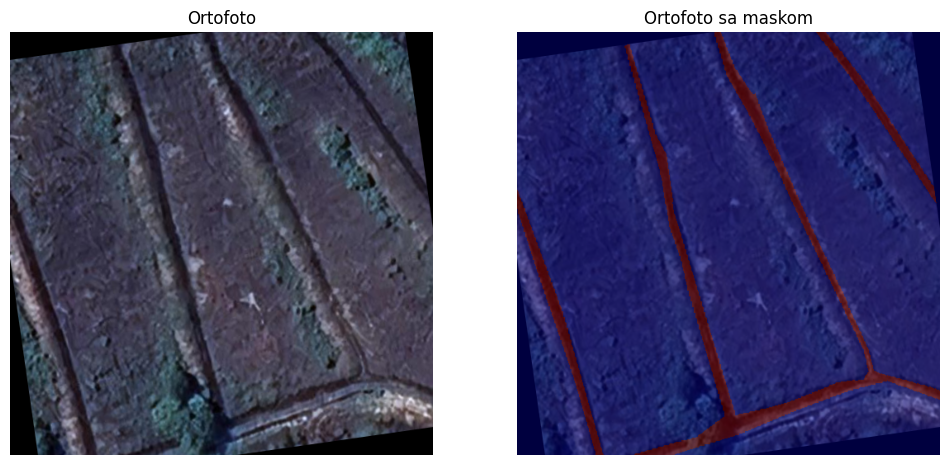

In [ ]:
TRAIN_IMG_DIR = "/content/drive/MyDrive/DataSet/train/images"
TRAIN_MASK_DIR = "/content/drive/MyDrive/DataSet/train/masks"
VAL_IMG_DIR = "/content/drive/MyDrive/DataSet/val/images"
VAL_MASK_DIR = "/content/drive/MyDrive/DataSet/val/masks"

# Kreiranje Dataset i DataLoader objekata
train_dataset = WaterBodiesDataset(
    image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform=train_transform
)
val_dataset = WaterBodiesDataset(
    image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR, transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


def show_sample(image, mask):
    """
    Prikazuje primer slike i maske jednu pored druge.
    Ova funkcija ispravno rukuje PyTorch tenzorima koji dolaze iz Dataset-a.
    """
    # 'image' i 'mask' su na ulazu PyTorch Tenzori.

    # Vraćamo normalizovanu sliku u opseg [0, 1] kako bi se mogla prikazati.
    # Ovo radimo ručno koristeći PyTorch operacije.
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean
    # Osiguravamo da su vrednosti piksela unutar validnog opsega [0, 1]
    image = image.clamp(0, 1)

    # Matplotlib očekuje (visina, širina, kanali) format, pa moramo promeniti redosled osa.
    # Originalni tenzor je (kanali, visina, širina).
    image_np = image.permute(1, 2, 0).numpy()

    # Maska je već u (visina, širina) formatu, pa je samo konvertujemo.
    mask_np = mask.numpy()

    # Prikaz
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Ortofoto")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    # Prikaz maske sa providnošću preko slike
    plt.imshow(mask_np, cmap="jet", alpha=0.5)
    plt.title("Ortofoto sa maskom")
    plt.axis('off')

    plt.show()


print("Prikazivanje jednog primera iz trening skupa...")
try:
    # Ova linija vraća PyTorch Tenzore zahvaljujući ToTensorV2()
    image, mask = train_dataset[2]

    # Prosleđujemo tenzore ispravljenoj funkciji
    show_sample(image, mask)

except Exception as e:
    print(f"Došlo je do greške prilikom učitavanja ili prikazivanja primera: {e}")

**Implementacija DeepLabV3 modela**

Koristimo pre-trenirani DeepLabV3 sa ResNet-50 kao osnovom. Menjamo samo klasifikator da odgovara našem broju klasa (2: pozadina i voda).

In [ ]:
def get_model(num_classes):
    # Učitavanje pre-treniranog DeepLabV3 modela
    model = models.segmentation.deeplabv3_resnet50(weights='DeepLabV3_ResNet50_Weights.DEFAULT')

    # Menjamo klasifikator da odgovara broju klasa našeg problema
    # U DeepLabV3, to je 'classifier.4' sloj
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    return model

# Naš problem ima 2 klase: 0=pozadina, 1=voda
NUM_CLASSES = 2
model = get_model(num_classes=NUM_CLASSES).to(DEVICE)

**Trening modela**

Definišemo funkciju gubitka, optimizator i petlje za trening i validaciju.

In [ ]:
# Definicija hiperparametara
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 12

# Funkcija gubitka i optimizator
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    """Funkcija za jednu epohu treninga."""
    model.train()
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)

        predictions = model(data)['out']
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Ažuriranje progres trake
        loop.set_postfix(loss=loss.item())

# Petlja za trening
for epoch in range(NUM_EPOCHS):
    print(f"--- Epoha {epoch+1}/{NUM_EPOCHS} ---")
    train_one_epoch(train_loader, model, optimizer, loss_fn, DEVICE)
    # Čuvanje najboljeg modela.

# Sačuvati model nakon treninga
torch.save(model.state_dict(), "deeplabv3_water_segmentation.pth")

--- Epoha 1/25 ---


100%|██████████| 44/44 [01:06<00:00,  1.51s/it, loss=0.209]


--- Epoha 2/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.118]


--- Epoha 3/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.246]


--- Epoha 4/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.182]


--- Epoha 5/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0889]


--- Epoha 6/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0981]


--- Epoha 7/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.115]


--- Epoha 8/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.131]


--- Epoha 9/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.117]


--- Epoha 10/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.066]


--- Epoha 11/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0368]


--- Epoha 12/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.137]


--- Epoha 13/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0652]


--- Epoha 14/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0909]


--- Epoha 15/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.0647]


--- Epoha 16/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.0824]


--- Epoha 17/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.157]


--- Epoha 18/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.0576]


--- Epoha 19/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.064]


--- Epoha 20/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0571]


--- Epoha 21/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0664]


--- Epoha 22/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.0484]


--- Epoha 23/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.49s/it, loss=0.0366]


--- Epoha 24/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.0702]


--- Epoha 25/25 ---


100%|██████████| 44/44 [01:05<00:00,  1.48s/it, loss=0.054]


**Evaluacija modela**

Implementiraćemo metrike IoU i F1-score.

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    """
    Funkcija za računanje metrika (IoU, F1-score, tačnost) na datom skupu.
    """
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x)['out']
            preds = torch.argmax(preds, dim=1)

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Računanje Dice i IoU za svaku sliku u batch-u
            for i in range(preds.shape[0]):
                pred_i = preds[i].flatten()
                y_i = y[i].flatten()

                intersection = (pred_i & y_i).sum()

                # Dice / F1-score
                dice_score += (2. * intersection) / (pred_i.sum() + y_i.sum() + 1e-8)

                # IoU / Jaccard
                union = (pred_i | y_i).sum()
                iou_score += intersection / (union + 1e-8)

    print(f"Tačnost piksela: {num_correct/num_pixels*100:.2f}%")
    print(f"Prosečan F1-score (Dice): {dice_score/len(loader.dataset):.4f}")
    print(f"Prosečan IoU (Jaccard): {iou_score/len(loader.dataset):.4f}")

    model.train()

print("\n--- Evaluacija na validacionom skupu ---")
check_accuracy(val_loader, model, device=DEVICE)


--- Evaluacija na validacionom skupu ---
Tačnost piksela: 97.53%
Prosečan F1-score (Dice): 0.9652
Prosečan IoU (Jaccard): 0.9341


**Vizualizacija predikcija**

Ova funkcija će prikazati original, stvarnu masku i predikciju modela jednu pored druge.

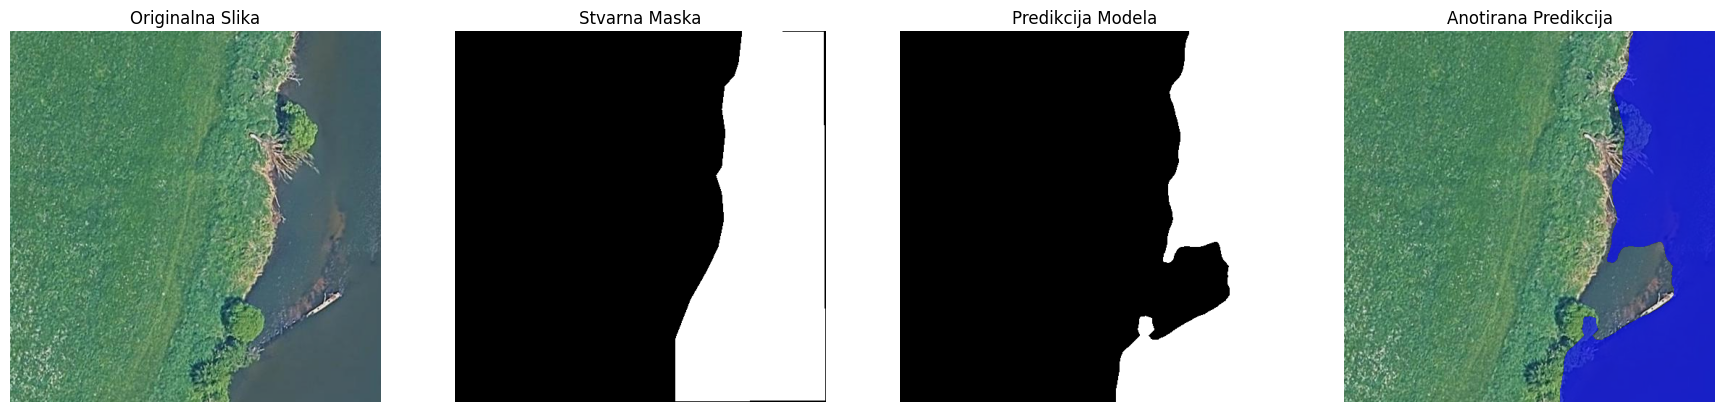

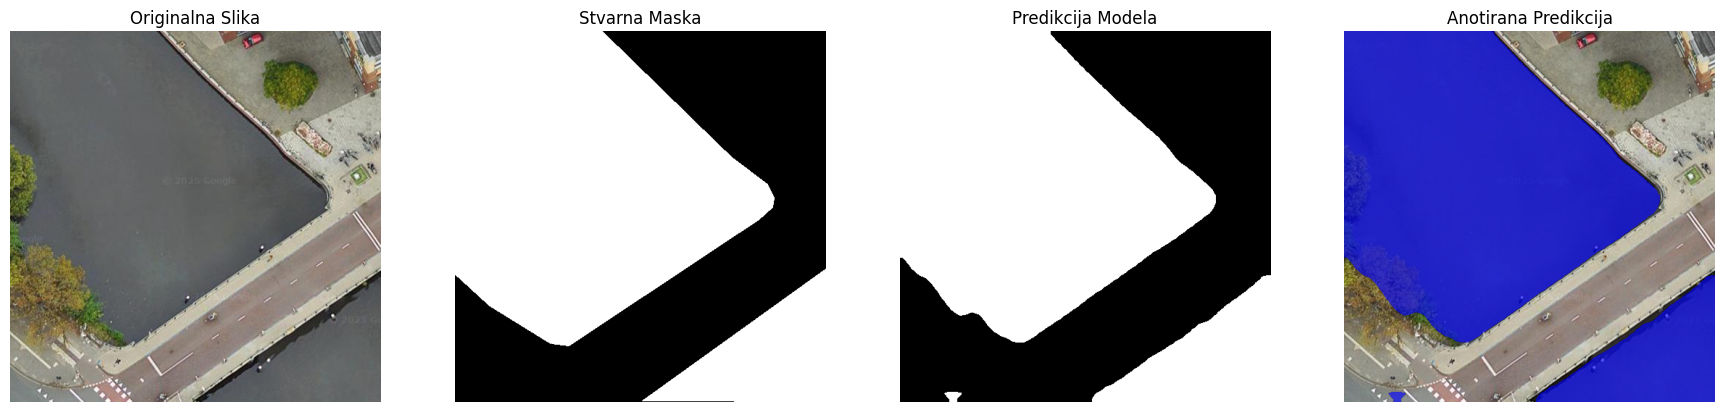

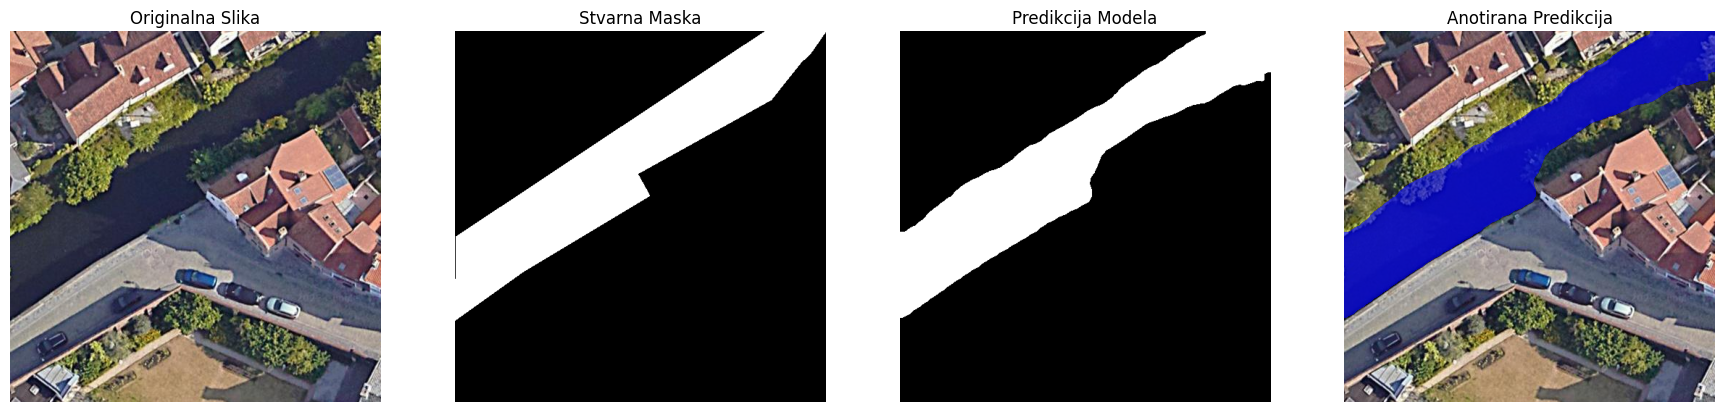

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    """
    Funkcija za čuvanje predikcija sa dodatnim prikazom anotirane originalne slike.
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)

        with torch.no_grad():
            preds = model(x)['out']
            preds = torch.argmax(preds, dim=1).cpu()

        # Uzimamo prvu sliku/masku/predikciju iz batch-a za prikaz
        original_image_tensor = x[0].cpu()
        ground_truth_mask_tensor = y[0]
        predicted_mask_tensor = preds[0]

        # --- Denormalizacija originalne slike za prikaz ---
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        denormalized_image_tensor = original_image_tensor * std + mean
        denormalized_image_tensor = denormalized_image_tensor.clamp(0, 1)

        # --- Konverzija u NumPy format za crtanje ---
        image_np = denormalized_image_tensor.permute(1, 2, 0).numpy()
        ground_truth_mask_np = ground_truth_mask_tensor.squeeze().numpy()
        predicted_mask_np = predicted_mask_tensor.numpy()

        custom_cmap = ListedColormap([(0, 0, 1, 0.8), 'dodgerblue'])
        # Povećavamo veličinu figure da stanu 4 slike
        plt.figure(figsize=(22, 5))

        # --- Slika 1: Originalna Slika ---
        plt.subplot(1, 4, 1)
        plt.imshow(image_np)
        plt.title("Originalna Slika")
        plt.axis('off')

        # --- Slika 2: Stvarna Maska ---
        plt.subplot(1, 4, 2)
        plt.imshow(ground_truth_mask_np, cmap='gray')
        plt.title("Stvarna Maska")
        plt.axis('off')

        # --- Slika 3: Predikcija Modela (crno-bela) ---
        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask_np, cmap='gray')
        plt.title("Predikcija Modela")
        plt.axis('off')

        # --- Slika 4: Anotirana Slika (Overlay) ---
        plt.subplot(1, 4, 4)
        # Prvo crtamo originalnu sliku kao pozadinu
        plt.imshow(image_np)

        # Kreiramo maskirani niz gde su samo vrednosti 1 (voda) vidljive
        masked_prediction = np.ma.masked_where(predicted_mask_np == 0, predicted_mask_np)

        # Preko originalne slike crtamo samo maskiranu predikciju
        # Koristimo 'jet' mapu boja (plava za niske vrednosti) i providnost `alpha`
        plt.imshow(masked_prediction, cmap=custom_cmap, alpha=0.8)
        plt.title("Anotirana Predikcija")
        plt.axis('off')

        # Čuvanje i prikaz figure
        plt.savefig(f"{folder}/prediction_{idx}.png")
        plt.show()

        # Prikazujemo samo nekoliko primera da ne pretrpamo izlaz
        if idx > 2:
            break

    model.train()

# Poziv funkcije
save_predictions_as_imgs(val_loader, model, device=DEVICE)

**Inferencija na velikim slikama (Sliding Window)**

Za slike dimenzija 10520x10520, ne možemo ih učitati cele u memoriju GPU-a. Rešenje je da se slika iseče na manje delove (npr. 512x512), izvrši predikcija na svakom delu, i zatim se rezultati spoje nazad.


100%|██████████| 40/40 [03:20<00:00,  5.02s/it]


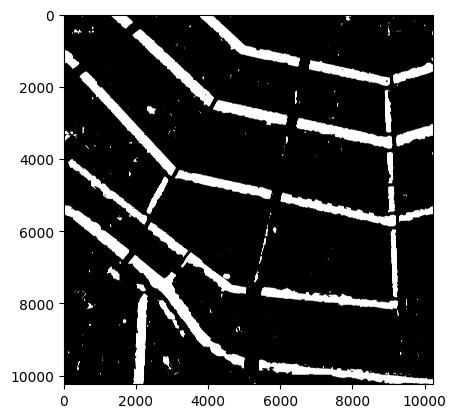

True

In [ ]:
def predict_large_image(model, large_image_path, patch_size=512, stride=256):
    """
    Vrši predikciju na velikoj slici koristeći sliding window pristup.
    """
    model.eval()

    # Učitavanje slike koristeći OpenCV
    large_image = cv2.imread(large_image_path)
    large_image_rgb = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
    h, w, _ = large_image_rgb.shape

    # Kreiranje prazne mape za predikcije
    prediction_map = np.zeros((h, w), dtype=np.uint8)

    # Normalizacija za model
    transform = A.Compose([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ])

    for y in tqdm(range(0, h, stride)):
        for x in range(0, w, stride):
            y_end = min(y + patch_size, h)
            x_end = min(x + patch_size, w)
            patch = large_image_rgb[y:y_end, x:x_end]

            # Preskoči ako je patch manji od minimalne veličine
            if patch.shape[0] < 64 or patch.shape[1] < 64:
                continue

            # Pad-ovanje patch-a ako nije tačne veličine 512x512
            padded_patch = cv2.copyMakeBorder(
                patch, 0, patch_size - patch.shape[0], 0, patch_size - patch.shape[1],
                cv2.BORDER_CONSTANT, value=0
            )

            # Priprema za model
            input_tensor = transform(image=padded_patch)["image"].unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                output = model(input_tensor)['out']
                pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

            # Isecanje originalne veličine patch-a iz predikcije
            pred_mask_cropped = pred_mask[:patch.shape[0], :patch.shape[1]]

            # Postavljanje predikcije na odgovarajuće mesto u finalnoj mapi
            prediction_map[y:y_end, x:x_end] = pred_mask_cropped

    return prediction_map

# Primer upotrebe (potrebno je imati veliku sliku na putanji)
large_image_path = "/content/drive/MyDrive/satellite (9)_1.png"
final_prediction = predict_large_image(model, large_image_path)
plt.imshow(final_prediction, cmap='gray')
plt.show()
cv2.imwrite("/content/drive/MyDrive/satellite (9)_1.png", final_prediction * 255)

**Post-procesiranje (Raster u Vektor)**

Konačno, konvertujemo finalnu rastersku predikciju u poligone (vektorski format).


Učitavanje modela...
Model uspešno učitan na 'cuda' uređaj.


Predikcija na slici: 100%|██████████| 40/40 [03:15<00:00,  4.90s/it]


Prikazivanje i čuvanje rezultata...


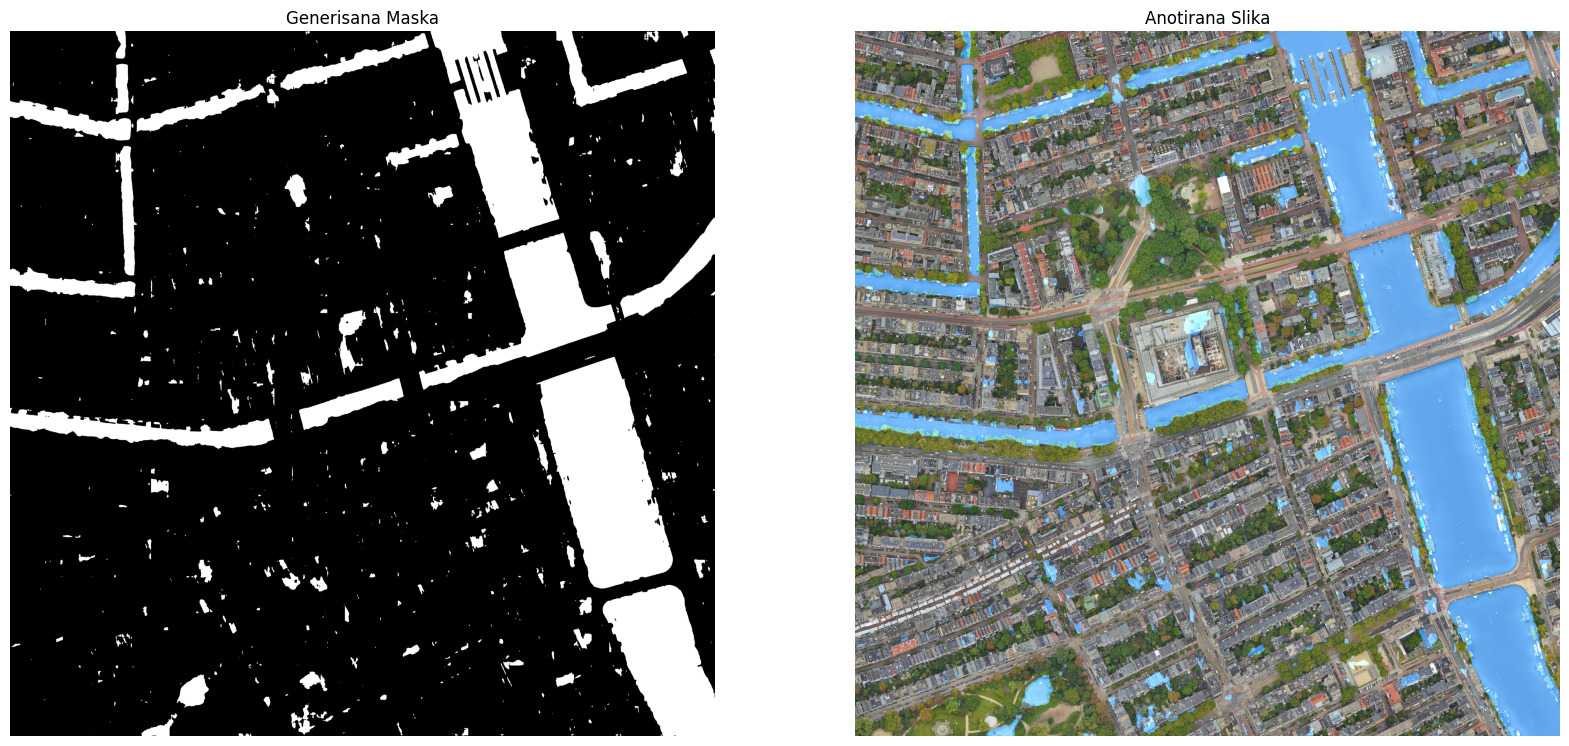

------------------------------
Maska sačuvana na: /content/drive/MyDrive/satellite_mask13.png
Anotirana slika sačuvana na: /content/drive/MyDrive/satellite_annotated13.png
Završeno.


In [6]:
import os
import cv2
import torch
import numpy as np
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Funkcija identična onoj za trening.

def create_deeplabv3_model(num_classes=2):
    """
    Funkcija koja kreira 'kostur' DeepLabV3 modela sa ResNet101 osnovom.
    """
    model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    return model

# Ova klasa sadrži svu logiku za obradu slike.

class ImagePredictor:
    def __init__(self, model, device, patch_size=512, stride=256):
        """
        Inicijalizacija prediktora.
        Args:
            model (torch.nn.Module): Učitan PyTorch model.
            device (str): Uređaj na kojem se vrši predikcija ('cuda' ili 'cpu').
            patch_size (int): Veličina isečka (patch-a).
            stride (int): Korak pomeranja prozora (sliding window).
        """
        self.model = model
        self.device = device
        self.patch_size = patch_size
        self.stride = stride

        # Definišemo transformaciju koja se primenjuje na svaki isečak
        self.transform = A.Compose([
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ])

        # Prebacujemo model u mod za evaluaciju odmah pri inicijalizaciji
        self.model.eval()

    def predict_and_annotate(self, image_path):
        """
        Vrši predikciju na velikoj slici i vraća masku i anotiranu sliku.
        """
        large_image = cv2.imread(image_path)
        if large_image is None:
            raise FileNotFoundError(f"Slika nije pronađena na putanji: {image_path}")

        h, w, _ = large_image.shape
        prediction_map = np.zeros((h, w), dtype=np.uint8)
        large_image_rgb = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)

        for y in tqdm(range(0, h, self.stride), desc="Predikcija na slici"):
            for x in range(0, w, self.stride):
                y_end = min(y + self.patch_size, h)
                x_end = min(x + self.patch_size, w)
                patch_rgb = large_image_rgb[y:y_end, x:x_end]

                if patch_rgb.shape[0] < 32 or patch_rgb.shape[1] < 32:
                    continue

                padded_patch = cv2.copyMakeBorder(
                    patch_rgb, 0, self.patch_size - patch_rgb.shape[0], 0, self.patch_size - patch_rgb.shape[1],
                    cv2.BORDER_CONSTANT, value=0
                )

                input_tensor = self.transform(image=padded_patch)["image"].unsqueeze(0).to(self.device)

                with torch.no_grad():
                    output = self.model(input_tensor)['out']
                    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

                pred_mask_cropped = pred_mask[:patch_rgb.shape[0], :patch_rgb.shape[1]]
                prediction_map[y:y_end, x:x_end] = np.maximum(prediction_map[y:y_end, x:x_end], pred_mask_cropped)

        # Kreiranje anotirane slike
        overlay = np.zeros_like(large_image, dtype=np.uint8)
        overlay[prediction_map == 1] = [255, 144, 30] # BGR za boju 'dodgerblue'
        annotated_image = cv2.addWeighted(large_image, 1.0, overlay, 0.6, 0)

        return prediction_map, annotated_image

if __name__ == "__main__":
    MODEL_PATH = "/content/drive/MyDrive/OGI Project Usmeni/deeplabv3_water_segmentation.pth"
    IMAGE_PATH = "/content/drive/MyDrive/OGI Project Usmeni/satellite (13)_1.png"
    MASK_SAVE_PATH = "/content/drive/MyDrive/satellite_mask13.png"
    ANNOTATED_SAVE_PATH = "/content/drive/MyDrive/satellite_annotated13.png"

    # --- Učitavanje modela ---
    print("Učitavanje modela...")
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Kreiramo "prazan" model
    model = create_deeplabv3_model(num_classes=2)

    # 2. Učitavamo sačuvane težine u njega
    model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))

    # 3. Prebacujemo model na odgovarajući uređaj
    model.to(DEVICE)
    print(f"Model uspešno učitan na '{DEVICE}' uređaj.")

    # --- Izvršavanje predikcije ---
    # Kreiramo instancu naše klase sa učitanim modelom
    predictor = ImagePredictor(model, device=DEVICE)

    # Pokrećemo predikciju
    final_mask, final_annotated = predictor.predict_and_annotate(IMAGE_PATH)

    # --- Prikazivanje i čuvanje rezultata ---
    print("Prikazivanje i čuvanje rezultata...")
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(final_mask, cmap='gray')
    plt.title("Generisana Maska")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_annotated, cv2.COLOR_BGR2RGB))
    plt.title("Anotirana Slika")
    plt.axis('off')

    plt.show()

    cv2.imwrite(MASK_SAVE_PATH, final_mask * 255)
    cv2.imwrite(ANNOTATED_SAVE_PATH, final_annotated)

    print("-" * 30)
    print(f"Maska sačuvana na: {MASK_SAVE_PATH}")
    print(f"Anotirana slika sačuvana na: {ANNOTATED_SAVE_PATH}")
    print("Završeno.")

In [ ]:
def raster_to_vector(raster_path, output_vector_path):
    """
    Konvertuje binarni raster u vektorski format (GeoJSON).
    """
    with rasterio.open(raster_path) as src:
        # Čitanje prvog kanala (band)
        image = src.read(1)

        # Maska gde su vrednosti 1 (voda)
        mask = image == 1

        # Generisanje oblika (poligona) iz maske
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(
                shapes(image, mask=mask, transform=src.transform))
        )

        geometries = list(results)

        # Kreiranje GeoDataFrame-a
        if geometries:
            gdf = gpd.GeoDataFrame.from_features(geometries)
            gdf.set_crs(src.crs, inplace=True)
            gdf.to_file(output_vector_path, driver='GeoJSON')
            print(f"Vektori sačuvani u: {output_vector_path}")
        else:
            print("Nije pronađena nijedna vodena površina za vektorizaciju.")

# Kreiranje lažne rasterske predikcije za demonstraciju
dummy_prediction = np.zeros((512, 512), dtype=np.uint8)
cv2.rectangle(dummy_prediction, (100, 100), (300, 300), 1, -1) # Voda je vrednost 1
cv2.circle(dummy_prediction, (400, 400), 50, 1, -1)

# Za raster_to_vector je potreban geo-referenciran fajl, pa ga kreiramo
with rasterio.open(
    '/content/dummy_prediction.tif', 'w',
    driver='GTiff', height=dummy_prediction.shape[0], width=dummy_prediction.shape[1],
    count=1, dtype=str(dummy_prediction.dtype),
    crs='+proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # Primer CRS
) as dst:
    dst.write(dummy_prediction, 1)


# Pokretanje konverzije
raster_to_vector('/content/dummy_prediction.tif', '/content/vodene_povrsine.geojson')

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Vektori sačuvani u: /content/vodene_povrsine.geojson
